In [1]:
# Load used Python packages
import numpy as np
import pandas as pd
from SimPEG.utils import surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from pymatsolver import Pardiso as Solver
import matplotlib.pyplot as plt

>> Use cython version


## Step1: Load ERT resistivity data

In [2]:
# header = [,El-array,xA (m),xB (m),xM (m),xN (m),Global xA (m),Global xB (m),Global xM (m),Global xN (m),Rho (Ohm.m),Dev. Rho (%),SP (mV),VMN (mV),IAB (mA),Time (ms),Coef. k (m),Metal factor,yA (m),yB (m),yM (m),yN (m),Global yA (m),Global yB (m),Global yM (m),Global yN (m),zA (m),zB (m),zM (m),zN (m),Global zA (m),Global zB (m),Global zM (m),Global zN (m),N° electrode A,N° electrode B,N° electrode M,N° electrode N,Depth A (m),Depth B (m),Depth M (m),Depth N (m),Stack,Rs-Check,Vab (V),Pab (W),Rab (kOhm),Latitude,Longitude,UTM (WSG84),Name,Channel,Overload,Tx-Bat (V),Tx Temp. (°C),Rx-Bat (V),Rx Temp. (°C),Date,Gapfiller,Synch,Y Average tab raw 0,Y Average tab raw 10,Y Average tab raw 20,Y Average tab raw 30,Y Average tab raw 40,Y Average tab raw 50,Y Average tab raw 60,Y Average tab raw 70,Y Average tab raw 80,Y Average tab raw 90,Y Average tab raw 100,Y Average tab raw 110,Y Average tab raw 120,Y Average tab raw 130,Y Average tab raw 140,Y Average tab raw 150,Y Average tab raw 160,Y Average tab raw 170,Y Average tab raw 180,Y Average tab raw 190,Y Average tab raw 200,Y Average tab raw 210,Y Average tab raw 220,Y Average tab raw 230,Y Average tab raw 240,Y Average tab raw 250,Y Average tab raw 260,Y Average tab raw 270,Y Average tab raw 280,Y Average tab raw 290,Y Average tab raw 300,Y Average tab raw 310,Y Average tab raw 320,Y Average tab raw 330,Y Average tab raw 340,Y Average tab raw 350,Y Average tab raw 360,Y Average tab raw 370,Y Average tab raw 380,Y Average tab raw 390,Y Average tab raw 400,Y Average tab raw 410,Y Average tab raw 420,Y Average tab raw 430,Y Average tab raw 440,Y Average tab raw 450,Y Average tab raw 460,Y Average tab raw 470,Y Average tab raw 480,Y Average tab raw 490

In [3]:
# # initialize data_io object

In [4]:
# fnames = [
#     './data/TN_DD_F0.csv',
#     './data/TN_DD_F1.csv',
#     './data/TN_DD_F2.csv',
#     './data/TN_DD_F3.csv'
# ]

In [13]:
fnames = [
    './data/TN_MG_F0.csv',
    './data/TN_MG_F1.csv',
    './data/TN_MG_F2.csv',
    './data/TN_MG_F3.csv'
]

In [14]:
data_ios = []
surveys = []
for fname in fnames:
    df = pd.read_csv(fname, encoding= 'unicode_escape')
    n_data = df.shape[0]
    data_io = dc.IO()
    a = np.c_[df['xA (m)'].values, np.zeros(n_data)]
    b = np.c_[df['xB (m)'].values, np.zeros(n_data)]
    m = np.c_[df['xM (m)'].values, np.zeros(n_data)]
    n = np.c_[df['xN (m)'].values, np.zeros(n_data)]
    rho = df['Rho (Ohm.m)'].values # rho: apparent resistivity [ohm-m]
    dev_rho = df['Dev. Rho (%)'].values # rho: apparent resistivity [ohm-m]
    # create a survey object from the data_io object
    survey = data_io.from_abmn_locations_to_survey(
        a, b, m, n, 
        survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
        data_dc=rho, 
        data_dc_type='apparent_resistivity'# input data type
    )
    data_ios.append(data_io)
    surveys.append(survey)

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")
C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


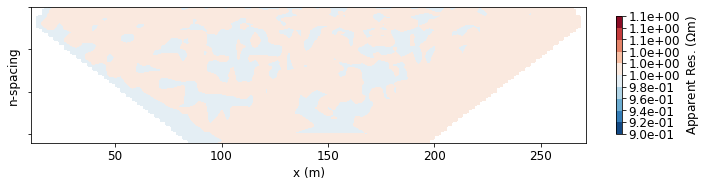

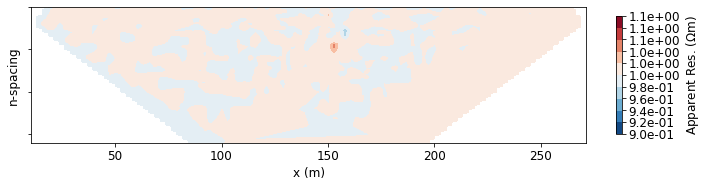

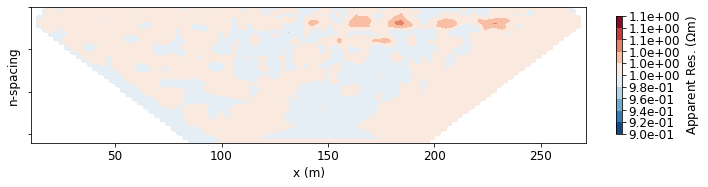

In [15]:
values_0 = data_ios[0].apparent_resistivity.copy()
for ii, data_io in enumerate(data_ios[1:]):
    ratio = data_io.apparent_resistivity.copy() / values_0
#     plt.plot(ratio)
    data_io.plotPseudoSection(cmap='RdBu_r', data=ratio, dataloc=False, scale='linear', clim=(0.9, 1.1), ncontour=10)

In [11]:
data_io.plotPseudoSection??

C:\Users\sgkan\Projects\simpeg\SimPEG\electromagnetics\static\resistivity\IODC.py:204: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


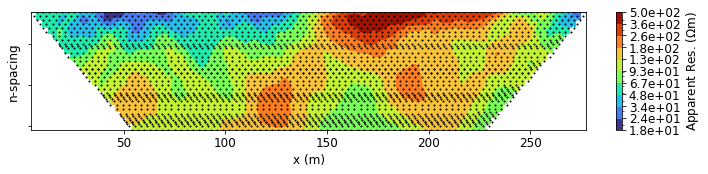

In [9]:
# parse out A, B, M, N electrodes and appparent resistivity 
df = pd.read_csv("./data/TN_DD_F0.csv", encoding= 'unicode_escape')
n_data = df.shape[0]
data_io = dc.IO()
a = np.c_[df['xA (m)'].values, np.zeros(n_data)]
b = np.c_[df['xB (m)'].values, np.zeros(n_data)]
m = np.c_[df['xM (m)'].values, np.zeros(n_data)]
n = np.c_[df['xN (m)'].values, np.zeros(n_data)]
rho = df['Rho (Ohm.m)'].values # rho: apparent resistivity [ohm-m]
dev_rho = df['Dev. Rho (%)'].values # rho: apparent resistivity [ohm-m]
# create a survey object from the data_io object
survey = data_io.from_abmn_locations_to_survey(
    a, b, m, n, 
    survey_type='dipole-dipole', # don't be confused dipole-dipole includes any type of arrays using four electrodes system
    data_dc=rho, 
    data_dc_type='apparent_resistivity'# input data type
)
# plot ert data on a pseudo-section
data_io.plotPseudoSection(cmap='turbo')

## Step2: Filter noisy data

In [10]:
# define conditions to remove data
# data_io.grids indicates location of the data on a pseudo-section
inds = abs(data_io.voltages) > 0.
# data_io.plotPseudoSection(cmap='turbo')
# plt.plot(data_io.grids[inds,0], data_io.grids[inds,1], 'rx')

In [11]:
data_io.voltages

array([-0.80249459, -0.24523124, -0.07952442, ..., -0.01753546,
       -0.48966671, -0.11910095])

In [12]:
inds.sum()

2955

In [13]:
inds.size

2955

In [14]:
# # Construct a new data io object with the filtered data
# data_io_filtered = dc.IO()
# survey = data_io_filtered.from_abmn_locations_to_survey(
#     data_io.a_locations[inds],
#     data_io.b_locations[inds],
#     data_io.m_locations[inds],
#     data_io.n_locations[inds],
#     survey_type='dipole-dipole', 
#     data_dc=data_io.apparent_resistivity[inds], 
#     data_dc_type='apparent_resistivity'
# )
# data_io_filtered.plotPseudoSection(cmap='turbo')

## Step 3: Create 2D tensor mesh

In [20]:
# create a 2D tensor mesh
mesh, _ = data_io.set_mesh(dx=1, dz=1, corezlength=5, pad_rate_z=1.2, npad_z=10)
# define inactive cells from a given topography
# ind_active = utils.surface2ind_topo(mesh, topo, method='linear')
# drape electrode locations onto the topography
# survey.drape_electrodes_on_topography(mesh, ind_active)
# plot mesh, active (yellow) & inactive (blue) cells
# fig, ax = plt.subplots(1,1, figsize=(20, 5))
# mesh.plot_image(ind_active, grid=True, grid_opts={'alpha':0.2, 'color': 'k'}, ax=ax)
# ax.plot(topo[:,0], topo[:,1], color='r')
# ax.set_aspect(1)

In [21]:
mesh.nC

4470

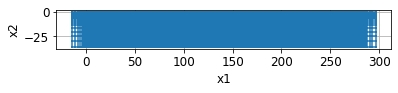

In [22]:
mesh.plot_grid()
plt.gca().set_aspect(1)

<AxesSubplot:xlabel='x1', ylabel='x2'>

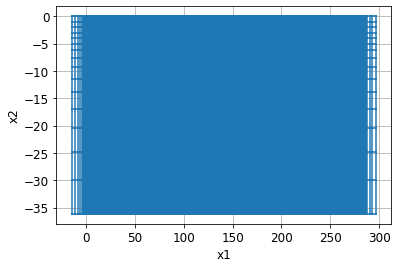

In [23]:
mesh.plot_grid()

logarithmic mean resistivity is 109.9 ohm-m


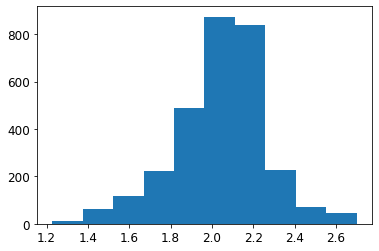

In [24]:
plt.hist(np.log10(rho))
print ("logarithmic mean resistivity is {:.1f} ohm-m".format(10**np.mean(np.log10(rho))))

## Step 4: Invert the ERT dat

In [25]:
data_io.voltages

array([-0.80249459, -0.24523124, -0.07952442, ..., -0.01753546,
       -0.48966671, -0.11910095])

In [26]:
data_io.geometric_factor(survey)

array([-0.01768388, -0.00442097, -0.00176839, ..., -0.00031578,
       -0.01768388, -0.00442097])

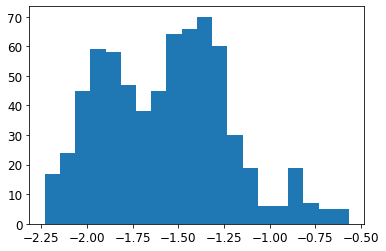

In [27]:
# create a mapping object
background_conductivity = np.log(1./100)
nC = int(mesh.n_cells)
conductivity_map = maps.ExpMap(mesh)

# define model
starting_conductivity_model = background_conductivity * np.ones(nC)

# create a data object
dc_data = data.Data(survey=survey, dobs=data_io.voltages)
# assign data uncertainty or error (defined as standard deviation)
standard_deviation = 0.03 * np.abs(dc_data.dobs) + 1e-3
dc_data.standard_deviation = standard_deviation
out = plt.hist(np.log10(data_io.voltages), bins=20)

In [28]:
from pymatsolver import Pardiso

In [29]:
# create a simulation object
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, storeJ=True, miniaturize=True
)
simulation.solver = Pardiso

In [30]:
# create a data misfit object
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# create the regularization (model objective function). here, 'p' defines the
# the norm of the smallness term, 'px' defines the norm of the smoothness
# in x and 'pz' defines the norm of the smoothness in z.
regmap = maps.IdentityMap(mesh=mesh)

reg = regularization.Sparse(
    mesh,
#     indActive=ind_active,
    mref=starting_conductivity_model,
    mapping=regmap,
    gradientType="total",
    alpha_s=1e-5,
    alpha_x=1,
    alpha_y=0.5,
)

reg.mrefInSmooth = False  # Include reference model in smoothness

p = 2
px = 1
pz = 0
reg.norms = np.c_[p, px, pz]

# define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40, maxIterCG=30)

# here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# define DC Inversion Directives
# ------------------------------
#
# here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# reach target misfit for L2 solution, then use IRLS until model stops changing.
update_IRLS = directives.Update_IRLS(
    max_irls_iterations=25, minGNiter=1, chifact_start=1.0,
    f_min_change=1e-4, fix_Jmatrix=False
)

# defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_dict = directives.SaveOutputDictEveryIteration()

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

target = directives.TargetMisfit()
directives_list = [
#     update_IRLS,
    starting_beta,
    save_dict,
    beta_schedule,
    target
]

#####################################################################
# Running the ERT Inversion
# ------------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.95e+02  3.37e+05  0.00e+00  3.37e+05    4.02e+04      0              
   1  3.47e+02  3.82e+04  3.32e+00  3.93e+04    6.28e+03      0              
   2  1.74e+02  6.15e+03  1.07e+01  8.00e+03    9.54e+02      0   Skip BFGS  
   3  8.68e+01  2.63e+03  1.91e+01  4.29e+03    2.78e+02      0   Skip BFGS  
   4  4.34e+01  1.65e+03  2.68e+01  2.82e+03    1.73e+02      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 3.3670e+04
1 : |xc-x_last| = 6.7006e+00 <= tolX*(1+|x0|) = 3.0889e+01
0 : |proj(x-g)-x

In [37]:
from matplotlib.colors import LogNorm
from discretize import utils as dis_utils
core_inds, mesh_core = dis_utils.extract_core_mesh(np.array([[0, 282], [-25, 0]]), mesh)

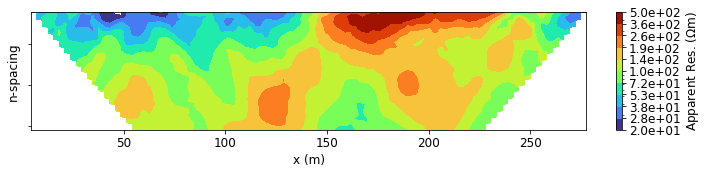

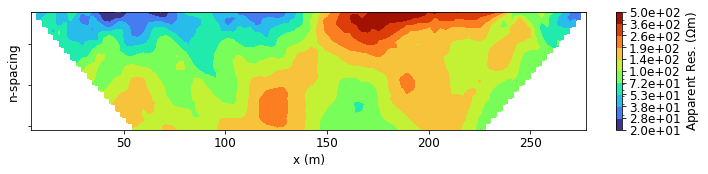

In [38]:
data_io.plotPseudoSection(cmap='turbo',clim=(20, 500), dataloc=False)
data_io.plotPseudoSection(cmap='turbo', data=inv_prob.dpred/data_io.G, clim=(20, 500), dataloc=False)

In [39]:
l2_model = recovered_conductivity_model

Text(0, 0.5, 'Elevation (m)')

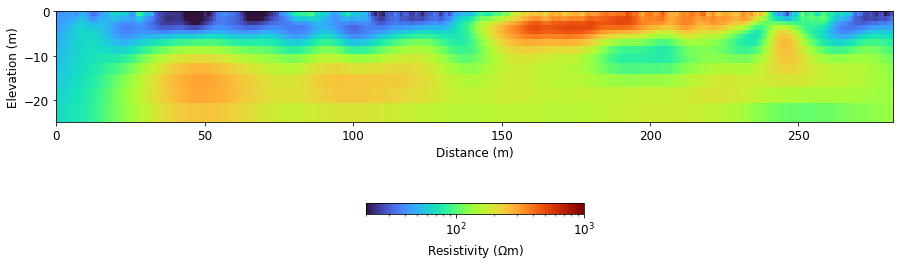

In [40]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
res = 1./(conductivity_map * l2_model)
out = mesh_core.plot_image(res[core_inds], pcolor_opts={'norm': LogNorm(vmin=20, vmax=1000), 'cmap':'turbo'},ax=ax)
ax.set_aspect(1.5)
cb = plt.colorbar(out[0], orientation='horizontal', fraction=0.02)
cb.set_label("Resistivity ($\Omega$m)")
ax.set_xlabel("Distance (m)")
ax.set_ylabel("Elevation (m)")